#MOGP LMC/ICM

In [1]:
import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib
import json, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize


base_path = Path("/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn")


if str(base_path ) not in sys.path:
    sys.path.insert(0, str(base_path ))

os.chdir(base_path )

from helpers_od_calibration_BN import load_kwargs_config
from src.simulation.data_loader import od_xml_to_df
from src.simulation.sumo_runner import create_taz_xml, simulate_od, parse_loop_data_xml_to_pandas
from src.utils.link_flow_analysis import (
    compute_squared_metric_all_edge as compute_squared_metric_all_edge ,
    compute_squared_metric_per_edge as compute_squared_metric_all_edge ,
)
%matplotlib inline


config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


{'BATCH_SIZE': 1,
 'BO_batch_size': 1,
 'BO_niter': 100,
 'BO_num_restarts': 10,
 'BO_raw_samples': 32,
 'BO_sample_shape': 128,
 'CLEANUP_INTERMEDIATE_FILES': True,
 'EARLY_STOP_DELTA': 0.001,
 'EARLY_STOP_MIN_ACQ': 0.0,
 'EARLY_STOP_PATIENCE': 10,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 100,
 'NUM_RESTARTS': 10,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv'),
 'kernel': 'matern-2p5',
 'model_name': 'bo_vanilla',
 'n_init_search': 10,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# create GT scenario 

In [2]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)



Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml
Total GT demand: 2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv


In [3]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)


# Run simulation
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/ground_truth/od.xml
    from     to  count
0  taz91  taz93  500.0
1  taz91  taz94  500.0
2  taz92  taz93  900.0
3  taz92  taz94  900.0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/ground_truth/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/net

In [4]:
df_edge_gt, df_trips_raw, out_csv = parse_loop_data_xml_to_pandas(
    base_path,
    sim_edge_out_gt,   # '.../ground_truth/sim_edge_data_quickstart.xml'
    prefix_output_gt,  # '.../ground_truth/sim'
    config["SUMO_PATH"],
)

print(df_edge_gt.head())
print(df_trips_raw.columns)

num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)


  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250
Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')
Number of GT edges: 14


In [7]:
print(num_gt_edges)

14


In [6]:
print(df_trips_raw.columns)


#edge_speed', 'edge_speedRelative','edge_timeLoss', 'edge_traveltime', 'edge_waitingTime','interval_nVehContrib', 'interval_harmonicMeanSpeed'

#other objectives

Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')


In [7]:
print(df_edge_gt.columns)

Index(['edge_id', 'interval_nVehContrib', 'interval_harmonicMeanSpeed'], dtype='object')


In [8]:
print(df_edge_gt.head())

  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250


In [5]:
gt_edge_data = df_edge_gt.sort_values(by=['interval_nVehContrib'], ascending=False).iloc[:num_gt_edges] # 14 


print(sim_edge_out_gt)

edge_ids = gt_edge_data["edge_id"].tolist()

gt_flows = (gt_edge_data.set_index("edge_id") # set index makes the edges IDs the dataframe index 
.loc[edge_ids, "interval_nVehContrib"]  #.loc[edge_ids, ...] = "Select rows where the index is in the edge_ids list and the col "interval_nVehContrib"
.values.astype(float)
) # gt_flow is a numpy array which is a vector of the flows on the edges 



output/quickstart_bo_vanilla_matern-2p5/ground_truth/sim_edge_data_quickstart.xml


In [ ]:


L = len(edge_ids) # number of edges, 14
weights_np = np.ones(L) / L    # [1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L] with L= 14 
#  np.ones(L) Create a 1-dimensional array of length L with all elements equal to 1, and then each element of the array is divided by L to get the weights.

print("Using UNIFORM weights:")
for e, w in zip(edge_ids, weights_np):
    print(f"  {e}: weight = {w:.4f}")


print(weights_np)

output/quickstart_bo_vanilla_matern-2p5/ground_truth/sim_edge_data_quickstart.xml
Using UNIFORM weights:
  D4: weight = 0.0714
  L14: weight = 0.0714
  L4: weight = 0.0714
  D5: weight = 0.0714
  D7: weight = 0.0714
  L10: weight = 0.0714
  L18: weight = 0.0714
  L5: weight = 0.0714
  L7: weight = 0.0714
  D2: weight = 0.0714
  L12: weight = 0.0714
  L2: weight = 0.0714
  L16: weight = 0.0714
  L15: weight = 0.0714
[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


In [10]:
print(gt_flows)

[1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]


In [11]:
print ("GT flows :", gt_flows[:])
print ("Weights :", weights_np[:])

GT flows : [1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]
Weights : [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


# sobol points 

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.double

dim_od = gt_od_df.shape[0] # dimension of the od vector
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)  # this is bound for the initial trainig points (od vector)



seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed)
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device)
print (x_0.shape)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)

print (train_X0) 
print (dim_od)

4
Random seed set to 42
torch.Size([10, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374],
        [ 208.3256, 1373.7338, 1810.7880,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4970],
        [1642.0144, 1849.8973, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8532, 1135.5953, 1953.6954]], dtype=torch.float64)
4


## evaluation of Sobol points sqaured metric

In [ ]:
from src.utils.link_flow_analysis import compute_squared_metric_per_edge

csv_path = Path(f"{config['simulation_run_path']}/initial_search/data_set_ods_icm_replicated.csv")

if csv_path.exists():
    print(f"Loading initial data from {csv_path}")
    df_initial = pd.read_csv(csv_path)
    
    
    train_X_list = []
    train_E_list = []
    S_list = []
    
    # Get x_* columns (OD inputs) - sorted by number
    x_cols = [col for col in df_initial.columns if col.startswith('x_')]
    x_cols.sort(key=lambda x: int(x.split('_')[1]))
    
    # Get e_* columns (per-edge errors)
    e_cols = [col for col in df_initial.columns if col.startswith('e_')]
    
    # Load each row
    for idx, row in df_initial.iterrows():
        train_X_list.append(row[x_cols].values.astype(float))
        train_E_list.append(row[e_cols].values.astype(float))
        S_list.append(float(row['loss']))
    
    print(f"  Loaded {len(train_X_list)} initial points")
    print(f"  OD dimension: {len(x_cols)}, Edges: {len(e_cols)}")
    
else:
    print(f"✗ CSV not found. Running {config['n_init_search']} initial simulations...")
    
    train_X_list = []      # each: np.array, shape [dim_od]
    train_E_list = []      # each: np.array, shape [L] (per-edge errors)
    S_list       = []      # each: scalar aggregated loss

    batch_data_i = []      # for CSV / plotting
    N_REP = 1           

    for i, x in enumerate(train_X0.tolist()):
        print(f"Initial OD: {i}")
        curr_od = np.array(x, dtype=float)
        print(curr_od)
        print(f"total expected demand: {np.sum(curr_od)}")


        simulation_run_path_init = f"{config['simulation_run_path']}/initial_search"
        Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

        # OD xml for this candidate (same for all reps)
        new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
        prefix_output_base = f"{simulation_run_path_init}/sobol_{i}"

        
        base_od = gt_od_df.copy() 
        base_od["count"] = curr_od
        base_od["count"] = [round(v, 1) for v in base_od["count"]]
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        
        per_edge_errors_reps = []
        sim_counts_reps = []

        for rep in range(N_REP):
            print(f" Replication {rep}")
            prefix_output_rep = f"{prefix_output_base}_rep{rep}"

            simulate_od(
                new_od_xml,
                prefix_output_rep,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
                sim_start_time=0,
                seed=rep,   # for different seed per replication, 
            )

            sim_edge_out_rep = f"{prefix_output_rep}_{config['EDGE_OUT_STR']}"
            curr_loop_stats_rep, _, _ = parse_loop_data_xml_to_pandas(
                base_path,
                sim_edge_out_rep,
                prefix_output_rep,
                config["SUMO_PATH"],
            )

            # printing simulated flows per edge 
            sim_counts = (
                curr_loop_stats_rep[curr_loop_stats_rep["edge_id"].isin(edge_ids)]
                .set_index("edge_id")["interval_nVehContrib"]
                .loc[edge_ids]  
                .values
            )

            print(f"\n--- Simulated flows for replication {rep} ---")
            for edge_id, count in zip(edge_ids, sim_counts):
                print(f"  {edge_id}: {count}")

            sim_counts_reps.append(sim_counts)

            # per-edge error for this replication (e_l(x))
            per_edge_errors_rep = compute_squared_metric_per_edge(
                df_true=gt_edge_data,
                df_simulated=curr_loop_stats_rep,
                edge_ids=edge_ids,
            )  # np.array [L]

            per_edge_errors_reps.append(per_edge_errors_rep)

        
        per_edge_errors_reps = np.stack(per_edge_errors_reps, axis=0)  # [N_REP, L]
        per_edge_errors = per_edge_errors_reps.mean(axis=0)            # [L]
        sim_counts_reps = np.stack(sim_counts_reps, axis=0)  # [N_REP, L]
        sim_flows = sim_counts_reps.mean(axis=0)  # [L]

        # aggregated scalar loss S(x) = Σ_l w_l e_l(x)
        S_x = float((per_edge_errors * weights_np).sum())
        print(f"aggregated loss S(x): {S_x}")

        
        train_X_list.append(curr_od.copy())
        train_E_list.append(per_edge_errors.copy())
        S_list.append(S_x)

        
        df_curr = pd.DataFrame(
            curr_od.reshape(1, -1),
            columns=[f"x_{k+1}" for k in range(curr_od.shape[0])]
        )
        df_curr["loss"] = S_x
        
       
        for edge_idx, edge_id in enumerate(edge_ids):
            df_curr[f"e_{edge_id}"] = per_edge_errors[edge_idx]
        
        for edge_idx, edge_id in enumerate(edge_ids):
            df_curr[f"sim_{edge_id}"] = sim_flows[edge_idx]
        
        batch_data_i.append(df_curr)

    # Save initial dataset
    df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
    df_initial_bo.to_csv(csv_path, index=False)
    print(f"✓ Saved initial data to {csv_path}")

✗ CSV not found. Running 20 initial simulations...
Initial OD: 0
[1995.02670765  208.73278379 1645.95770836  838.86432648]
total expected demand: 4688.5815262794495
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/initial_search/gt_od_quickstart_0.xml
    ▶ Replication 0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/initial_search/gt_od_quickstart_0.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/initial_search/sobol_0_rep0_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/initial_search/sobol_0_rep0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanil

## simulated flow 

In [24]:
df_initial = pd.read_csv(csv_path)

sim_cols = [c for c in df_initial.columns if c.startswith('sim_')]
sim_cols.sort(key=lambda x: x.split('_')[1] if x.split('_')[1].isdigit() else x)

if len(sim_cols) > 0:
    print("Simulated flows (first row):")
    for col in sim_cols:
        print(f"  {col}: {df_initial[col].iloc[19]}")

Simulated flows (first row):
  sim_D2: 3231.0
  sim_D4: 650.0
  sim_D5: 1766.0
  sim_D7: 2115.0
  sim_L10: 2115.0
  sim_L12: 3231.0
  sim_L14: 650.0
  sim_L15: 1301.0
  sim_L16: 185.0
  sim_L18: 1766.0
  sim_L2: 3231.0
  sim_L4: 650.0
  sim_L5: 1766.0
  sim_L7: 2115.0


# GT

In [17]:

print(gt_edge_data)

   edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
1       D4                1800.0                    8.527143
6      L14                1800.0                   11.386250
11      L4                1800.0                    9.915000
2       D5                1400.0                   11.488750
3       D7                1400.0                   11.294444
4      L10                1400.0                   11.441250
9      L18                1400.0                   11.635000
12      L5                1400.0                   11.353750
13      L7                1400.0                   11.046667
0       D2                1000.0                    8.445000
5      L12                1000.0                   11.410000
10      L2                1000.0                   10.498000
8      L16                 900.0                   11.863750
7      L15                 500.0                   12.054000


# duplicated edges 
D4, L14, L4

D5, L5, L18

D7,L10,L7

D2, L12, L2

L16 

L15

Edge	from → to

D2	    91→911

L2	    911→1

L12	    1→6

L10	    6→5

L7	    5→914

D7	    914→94

D4	    92→912

L4	    912→2

L14	    2→3

L18	    3→4

L5	    4→913

D5	    913→93

L15	    6→3

L16	    3→6

In [37]:
print (f"errors aggregated {S_list}") # USED FOR BEST S INITIAL  
print (f"training od {train_X_list}")

errors aggregated [1.5431797909153078, 0.8662538000215959, 0.0661608171903682, 1.2759624877443039, 0.5627743271424971, 0.18640392383831839, 0.043419478350070186, 2.0360066192635786, 0.8334976954612531, 0.587408248749235, 0.4031089462261095, 1.3064210696109129, 0.5295852875139474, 0.6260342739085053, 0.49058830144332854, 1.8242497358816538, 1.4887928176942733, 0.44947075042292045, 0.4911170025915128, 1.4529777107943707]
training od [array([1995.02670765,  208.73278379, 1645.95770836,  838.86432648]), array([ 905.4017663 , 1676.13458633,  146.54093981, 1232.33985901]), array([ 436.36757135,  700.44517517, 1395.85351944,  347.93174267]), array([1463.98448944, 1168.59400272,  896.61258459, 1706.4114809 ]), array([1172.46508598,  780.60382605,  309.82995033, 1819.23735142]), array([ 208.32563937, 1373.73375893, 1810.78803539,  236.28084362]), array([ 738.9138937 ,  257.48419762,  559.97943878, 1367.49696732]), array([1642.01438427, 1849.89726543, 1060.6096983 ,  702.4101615 ]), array([1538.

## inspecting fit 

In [38]:

import numpy as np
import torch

from botorch.utils.transforms import normalize
from botorch.fit import fit_gpytorch_mll

from MOGP.helpers_MOGP import initialize_icm_gp

dtype  = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [34]:
train_X_icm_init = torch.tensor(np.array(train_X_list), dtype=dtype, device=device)  # [20, 4]
train_Y_raw_init = torch.tensor(np.array(train_E_list), dtype=dtype, device=device)   # [20, 14]

print(train_X_icm_init.shape)
print(train_Y_raw_init.shape)

torch.Size([20, 4])
torch.Size([20, 14])


In [39]:
N0, d = train_X_icm_init.shape
L     = train_Y_raw_init.shape[1]

max_demand = 2000.0
bounds = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.full((d,), max_demand, dtype=dtype, device=device),
])

# per-task standardization 
y_mean = train_Y_raw_init.mean(dim=0, keepdim=True)                # [1, L]
y_std  = train_Y_raw_init.std(dim=0, keepdim=True).clamp_min(1e-6) # [1, L]
train_Y_icm = (train_Y_raw_init - y_mean) / y_std                  # [N0, L]

# normalize inputs 
train_X_norm = normalize(train_X_icm_init, bounds=bounds)          # [N0, d]

print("Shapes:")
print("  train_X_norm :", train_X_norm.shape)
print("  train_Y_icm  :", train_Y_icm.shape)
print("  y_mean/std   :", y_mean.shape, y_std.shape)


Shapes:
  train_X_norm : torch.Size([20, 4])
  train_Y_icm  : torch.Size([20, 14])
  y_mean/std   : torch.Size([1, 14]) torch.Size([1, 14])


In [40]:
rank = config.get("rank", 1)


icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=rank) # normalized inputs and standardized errors 
icm_model = icm_model.to(device=device, dtype=dtype)
#icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
mll = mll.to(device=device, dtype=dtype)


# find the optimal hyperparameters 
icm_model.train()
mll.train()

fit_gpytorch_mll(mll)

print("✓ Initial ICM fit done.")


✓ Initial ICM fit done.


In [42]:
icm_model.eval()

with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix  # [L, L] (dense)
    B = 0.5 * (B + B.T)    # enforce symmetry
    evals_B = torch.linalg.eigvalsh(B)

print(f"B shape: {B.shape}")
print(f"min eig(B): {evals_B.min().item():.6e}")
print(f"max eig(B): {evals_B.max().item():.6e}")
print("top 10 eig(B):", torch.sort(evals_B, descending=True).values[:10].detach().cpu().numpy())

# quick “rank-ish” sanity (optional)
if L >= 3:
    e = torch.sort(evals_B, descending=True).values
    print("ratio e3/e2:", (e[2] / (e[1] + 1e-30)).item())


B shape: torch.Size([14, 14])
min eig(B): 1.853436e-10
max eig(B): 1.239952e+02
top 10 eig(B): [1.23995238e+02 2.37273315e+01 2.37107791e+01 2.32386606e+01
 8.72617949e+00 6.14558541e+00 6.14093978e+00 6.11216156e+00
 3.41471400e-03 3.09869660e-03]
ratio e3/e2: 0.999302390285969


In [ ]:
# Inspect Kf: latent (noise-free) full ICM covariance
#           PSD but often singular -> Cholesky NOT expected

icm_model.eval()

with torch.no_grad():
    f  = icm_model(train_X_norm)
    Kf = f.covariance_matrix           # [N0*L, N0*L]
    Kf = 0.5 * (Kf + Kf.T)
    evals_Kf = torch.linalg.eigvalsh(Kf)

print(f"Kf shape: {Kf.shape}  (expected {(N0*L, N0*L)})")
print(f"min eig(Kf): {evals_Kf.min().item():.6e}")
print(f"max eig(Kf): {evals_Kf.max().item():.6e}")
print("smallest 10 eig(Kf):", torch.sort(evals_Kf).values[:10].detach().cpu().numpy())


Kf shape: torch.Size([280, 280])  (expected (280, 280))
min eig(Kf): 1.383845e-13
max eig(Kf): 1.665674e-02
smallest 10 eig(Kf): [1.38384502e-13 1.63586023e-13 1.73840221e-13 2.01910320e-13
 2.39457507e-13 2.79249085e-13 2.81895311e-13 3.50241010e-13
 3.62790551e-13 4.35297340e-13]


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [53]:
# inspecting the covarance as K_y = K_f + noise 

icm_model.eval()
icm_model.likelihood.eval()

with torch.no_grad():
    f = icm_model(train_X_norm)
    Ky = icm_model.likelihood(f).covariance_matrix  # includes noise
    Ky = 0.5 * (Ky + Ky.T)
    evals = torch.linalg.eigvalsh(Ky)


evals = torch.linalg.eigvalsh(Ky)

print("min eig(Ky):", evals.min().item())
print("max eig(Ky):", evals.max().item())
print("cond(Ky) ~:", (evals.max() / evals.clamp_min(1e-18).min()).item())

Lchol, info = torch.linalg.cholesky_ex(Ky)
print("Ky cholesky ok?", info.item() == 0, "info:", info.item())


min eig(Ky): 0.00019999999762722385
max eig(Ky): 1.0167532623301558
cond(Ky) ~: 5083.766371963977
Ky cholesky ok? True info: 0


In [52]:
# Inspect )K_y: observed covariance (with likelihood noise)
#      This is the one that must be SPD -> Cholesky should work

icm_model.eval()
icm_model.likelihood.eval()

with torch.no_grad():
    f  = icm_model(train_X_norm)
    Ky = icm_model.likelihood(f).covariance_matrix   # [N0*L, N0*L]
    Ky = 0.5 * (Ky + Ky.T)
    evals_Ky = torch.linalg.eigvalsh(Ky)

print(f"Ky shape: {Ky.shape}  (expected {(N0*L, N0*L)})")
print(f"min eig(Ky): {evals_Ky.min().item():.6e}")
print(f"max eig(Ky): {evals_Ky.max().item():.6e}")

# Cholesky test (no jitter)
Lchol, info = torch.linalg.cholesky_ex(Ky)
print("Cholesky OK:", info.item() == 0, " | info:", info.item())

# condition number estimate (can be big, that’s fine, but huge -> numerical pain)
cond_est = (evals_Ky.max() / (evals_Ky.min().abs() + 1e-30)).item()
print(f"cond_est(Ky): {cond_est:.3e}")


Ky shape: torch.Size([280, 280])  (expected (280, 280))
min eig(Ky): 2.000000e-04
max eig(Ky): 1.016753e+00
Cholesky OK: True  | info: 0
cond_est(Ky): 5.084e+03


In [ ]:

icm_model.eval()
icm_model.likelihood.eval()

with torch.no_grad():
    lik = icm_model.likelihood

    # Most common: per-task noise (shape [L])
    if hasattr(lik, "task_noises"):
        noise = lik.task_noises

    # Sometimes: shared noise (shape [1]) or task noise (shape [L])
    elif hasattr(lik, "noise"):
        noise = lik.noise

    # Fallback: search inside named parameters
    else:
        params = dict(lik.named_parameters())
        # common parameter names in gpytorch likelihoods
        for k in ["raw_task_noises", "raw_noise"]:
            if k in params:
                noise = params[k]
                break
        else:
            raise RuntimeError(
                "Couldn't find noise on likelihood. Available attrs: "
                + ", ".join([a for a in dir(lik) if "noise" in a])
            )

print("Likelihood class:", type(icm_model.likelihood).__name__)
print("noise shape:", tuple(noise.shape))
print("noise values:", noise.detach().cpu().numpy())

# If you got raw_* parameters, you can still print them (they are unconstrained)
print("\nNamed params containing 'noise':")
for name, p in icm_model.likelihood.named_parameters():
    if "noise" in name:
        print(" ", name, tuple(p.shape))



Likelihood class: MultitaskGaussianLikelihood
noise shape: (14,)
noise values: [9.99938626e-01 9.99858722e-01 9.98004069e-01 4.29987551e-02
 1.86779022e-04 1.86073394e-04 9.99583014e-01 4.47596647e-02
 1.43155703e-04 1.00051359e-04 1.00016067e-04 1.00022057e-04
 8.86749592e-01 1.20536552e-04]

Named params containing 'noise':
  raw_task_noises (14,)
  raw_noise (1,)


RAW ERROR STATISTICS (before standardization)

Shape: (20, 14)

Per-task statistics:

  Task 0 (edge D4):
    Mean:  0.260685
    Std:   0.297486
    Min:   0.000446
    Max:   1.148469
    Range: 1.148024
    CV (coefficient of variation = std/mean): 1.1412

  Task 1 (edge L14):
    Mean:  0.260685
    Std:   0.297486
    Min:   0.000446
    Max:   1.148469
    Range: 1.148024
    CV (coefficient of variation = std/mean): 1.1412

  Task 2 (edge L4):
    Mean:  0.260685
    Std:   0.297486
    Min:   0.000446
    Max:   1.148469
    Range: 1.148024
    CV (coefficient of variation = std/mean): 1.1412

  Task 3 (edge D5):
    Mean:  0.467544
    Std:   0.609834
    Min:   0.003431
    Max:   2.562286
    Range: 2.558856
    CV (coefficient of variation = std/mean): 1.3043

  Task 4 (edge D7):
    Mean:  0.509637
    Std:   0.462785
    Min:   0.006984
    Max:   1.338980
    Range: 1.331995
    CV (coefficient of variation = std/mean): 0.9081

  Task 5 (edge L10):
    Mean:  0.509637
  

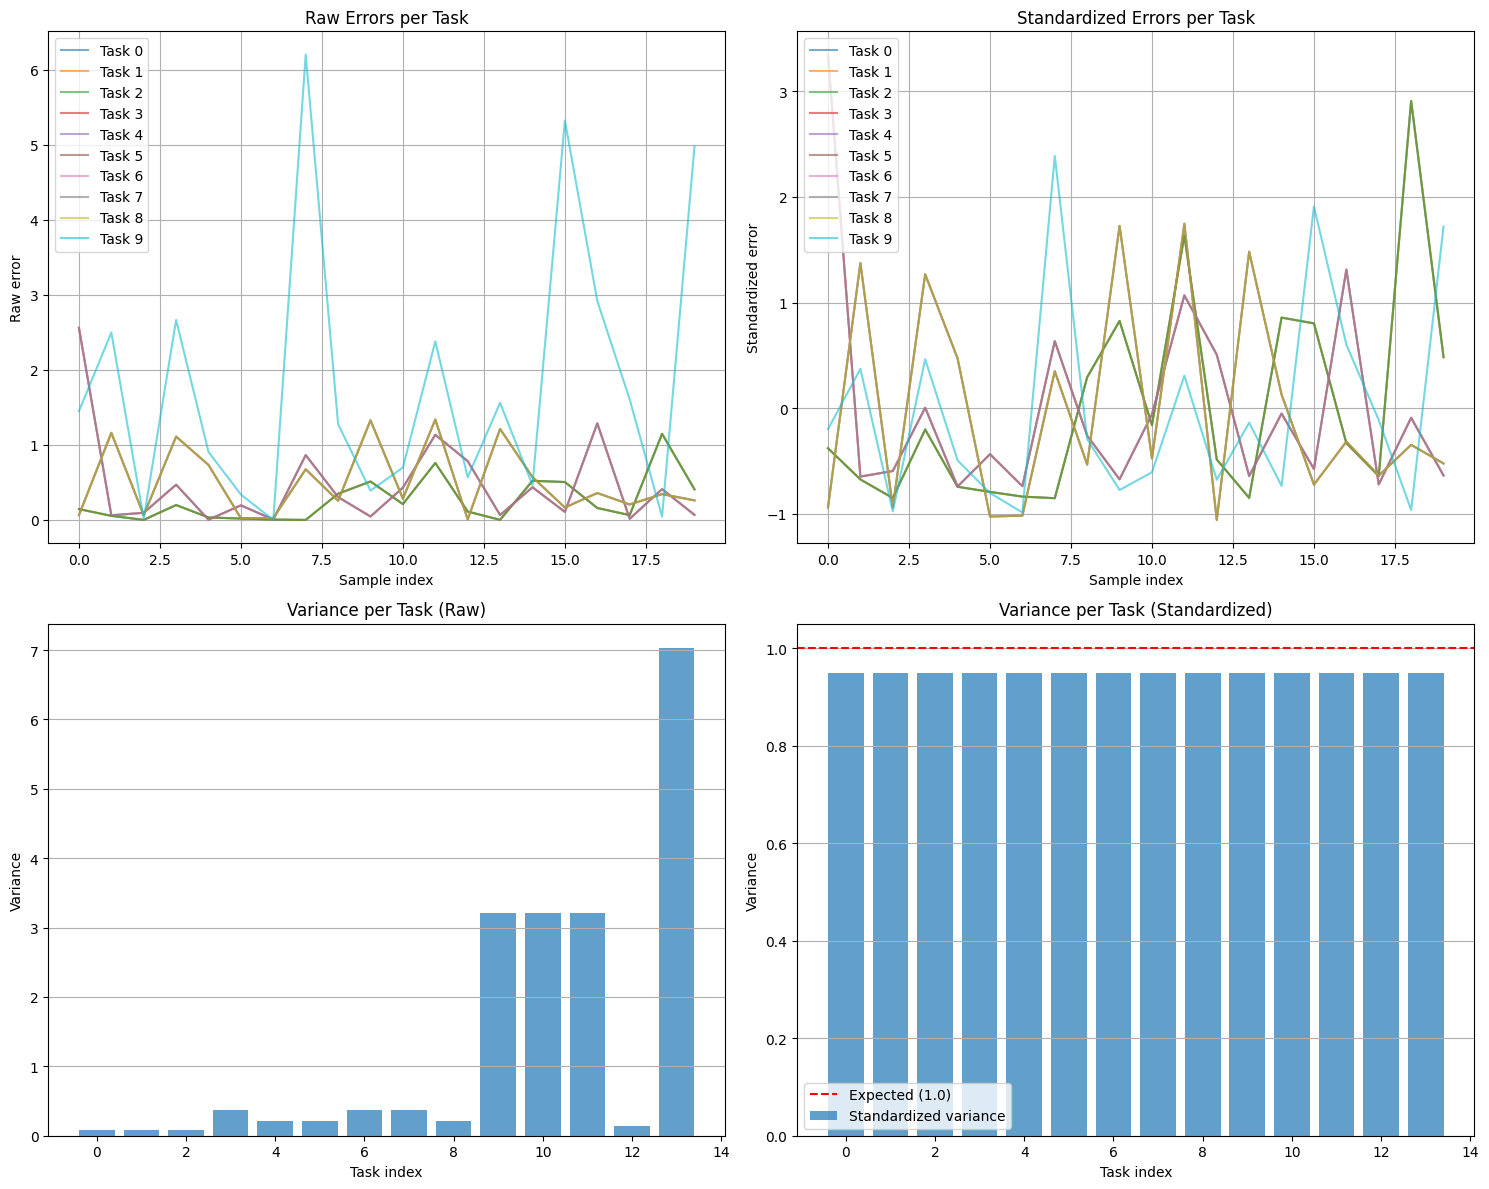


✓ Analysis complete!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Raw errors (before standardization)
train_Y_raw = train_Y_raw_init.cpu().numpy()  # [N, L]

# Standardized errors
train_Y_std = train_Y_icm.cpu().numpy()  # [N, L]

print("="*80)
print("RAW ERROR STATISTICS (before standardization)")
print("="*80)
print(f"\nShape: {train_Y_raw.shape}")
print(f"\nPer-task statistics:")
for i, edge_id in enumerate(edge_ids):
    task_data = train_Y_raw[:, i]
    print(f"\n  Task {i} (edge {edge_id}):")
    print(f"    Mean:  {task_data.mean():.6f}")
    print(f"    Std:   {task_data.std():.6f}")
    print(f"    Min:   {task_data.min():.6f}")
    print(f"    Max:   {task_data.max():.6f}")
    print(f"    Range: {task_data.max() - task_data.min():.6f}")
    print(f"    CV (coefficient of variation = std/mean): {task_data.std() / (abs(task_data.mean()) + 1e-10):.4f}")

print("\n" + "="*80)
print("STANDARDIZED ERROR STATISTICS")
print("="*80)
print(f"\nShape: {train_Y_std.shape}")
print(f"\nPer-task statistics (after standardization):")
for i, edge_id in enumerate(edge_ids):
    task_data = train_Y_std[:, i]
    print(f"\n  Task {i} (edge {edge_id}):")
    print(f"    Mean:  {task_data.mean():.6f} (should be ~0)")
    print(f"    Std:   {task_data.std():.6f} (should be ~1)")
    print(f"    Min:   {task_data.min():.6f}")
    print(f"    Max:   {task_data.max():.6f}")
    print(f"    Range: {task_data.max() - task_data.min():.6f}")

# Check standardization parameters
print("\n" + "="*80)
print("STANDARDIZATION PARAMETERS")
print("="*80)
y_mean = train_Y_raw_init.mean(dim=0, keepdim=True).cpu().numpy()  # [1, L]
y_std = train_Y_raw_init.std(dim=0, keepdim=True).cpu().numpy()    # [1, L]

print(f"\nPer-task standardization:")
for i, edge_id in enumerate(edge_ids):
    print(f"  Task {i} (edge {edge_id}):")
    print(f"    Mean (subtracted): {y_mean[0, i]:.6f}")
    print(f"    Std  (divided by): {y_std[0, i]:.6f}")

# Check for outliers
print("\n" + "="*80)
print("OUTLIER DETECTION")
print("="*80)
for i, edge_id in enumerate(edge_ids):
    task_data_raw = train_Y_raw[:, i]
    task_data_std = train_Y_std[:, i]
    
    # IQR method for outliers
    Q1_raw = np.percentile(task_data_raw, 25)
    Q3_raw = np.percentile(task_data_raw, 75)
    IQR_raw = Q3_raw - Q1_raw
    outliers_raw = (task_data_raw < (Q1_raw - 1.5*IQR_raw)) | (task_data_raw > (Q3_raw + 1.5*IQR_raw))
    
    Q1_std = np.percentile(task_data_std, 25)
    Q3_std = np.percentile(task_data_std, 75)
    IQR_std = Q3_std - Q1_std
    outliers_std = (task_data_std < (Q1_std - 1.5*IQR_std)) | (task_data_std > (Q3_std + 1.5*IQR_std))
    
    print(f"\n  Task {i} (edge {edge_id}):")
    print(f"    Outliers (raw): {outliers_raw.sum()}/{len(task_data_raw)} ({100*outliers_raw.sum()/len(task_data_raw):.1f}%)")
    print(f"    Outliers (std): {outliers_std.sum()}/{len(task_data_std)} ({100*outliers_std.sum()/len(task_data_std):.1f}%)")

# Check variance across tasks
print("\n" + "="*80)
print("VARIANCE ANALYSIS")
print("="*80)
var_raw = train_Y_raw.var(axis=0)
var_std = train_Y_std.var(axis=0)

print(f"\nVariance per task (raw):")
for i, edge_id in enumerate(edge_ids):
    print(f"  Task {i} (edge {edge_id}): {var_raw[i]:.6f}")

print(f"\nVariance per task (standardized):")
for i, edge_id in enumerate(edge_ids):
    print(f"  Task {i} (edge {edge_id}): {var_std[i]:.6f} (should be ~1.0)")

# Check correlation between tasks
print("\n" + "="*80)
print("TASK CORRELATIONS")
print("="*80)
corr_matrix = np.corrcoef(train_Y_raw.T)
print(f"\nCorrelation matrix shape: {corr_matrix.shape}")
print(f"Mean absolute correlation (off-diagonal): {np.abs(corr_matrix - np.eye(L)).sum() / (L*(L-1)):.4f}")

# Visualizations
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Raw errors per task
ax = axes[0, 0]
for i in range(min(L, 10)):  # Show first 10 tasks
    ax.plot(train_Y_raw[:, i], alpha=0.6, label=f'Task {i}')
ax.set_xlabel('Sample index')
ax.set_ylabel('Raw error')
ax.set_title('Raw Errors per Task')
ax.legend()
ax.grid(True)

# 2. Standardized errors per task
ax = axes[0, 1]
for i in range(min(L, 10)):
    ax.plot(train_Y_std[:, i], alpha=0.6, label=f'Task {i}')
ax.set_xlabel('Sample index')
ax.set_ylabel('Standardized error')
ax.set_title('Standardized Errors per Task')
ax.legend()
ax.grid(True)

# 3. Variance comparison
ax = axes[1, 0]
ax.bar(range(L), var_raw, alpha=0.7, label='Raw variance')
ax.set_xlabel('Task index')
ax.set_ylabel('Variance')
ax.set_title('Variance per Task (Raw)')
ax.grid(True, axis='y')

# 4. Standardized variance
ax = axes[1, 1]
ax.bar(range(L), var_std, alpha=0.7, label='Standardized variance')
ax.axhline(y=1.0, color='r', linestyle='--', label='Expected (1.0)')
ax.set_xlabel('Task index')
ax.set_ylabel('Variance')
ax.set_title('Variance per Task (Standardized)')
ax.legend()
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")

In [26]:
print("Tasks with high variance:")
high_var_tasks = [10, 11, 12, 14]
for task_idx in high_var_tasks:
    if task_idx < len(edge_ids):
        print(f"  Task {task_idx}: edge {edge_ids[task_idx]}")

Tasks with high variance:
  Task 10: edge L12
  Task 11: edge L2
  Task 12: edge L16


In [28]:
# Check actual number of tasks
L = train_Y_raw.shape[1]
print(f"Number of tasks: {L}")
print(f"Task indices: 0 to {L-1}")

# Find tasks with high variance
var_raw = train_Y_raw.var(axis=0)
high_var_threshold = 2.0  # Tasks with variance > 2.0

print("\n" + "="*80)
print("TASKS WITH HIGH VARIANCE")
print("="*80)
high_var_tasks = []
for task_idx in range(L):
    if var_raw[task_idx] > high_var_threshold:
        high_var_tasks.append(task_idx)
        edge_id = edge_ids[task_idx] if task_idx < len(edge_ids) else f"unknown"
        print(f"\n  Task {task_idx} (edge {edge_id}):")
        print(f"    Raw variance: {var_raw[task_idx]:.4f}")
        print(f"    Raw errors: mean={train_Y_raw[:, task_idx].mean():.4f}, "
              f"std={train_Y_raw[:, task_idx].std():.4f}")
        print(f"    Raw errors range: [{train_Y_raw[:, task_idx].min():.4f}, "
              f"{train_Y_raw[:, task_idx].max():.4f}]")

# Inspect the highest variance task
if len(high_var_tasks) > 0:
    highest_var_task = high_var_tasks[np.argmax([var_raw[i] for i in high_var_tasks])]
    print("\n" + "="*80)
    print(f"TASK WITH HIGHEST VARIANCE: Task {highest_var_task}")
    print("="*80)
    
    task_idx = highest_var_task
    task_raw = train_Y_raw[:, task_idx]
    task_std = train_Y_std[:, task_idx]
    edge_id = edge_ids[task_idx] if task_idx < len(edge_ids) else "unknown"
    
    print(f"\nEdge: {edge_id}")
    print(f"\nRaw errors:")
    print(f"  Mean:  {task_raw.mean():.6f}")
    print(f"  Std:   {task_raw.std():.6f}")
    print(f"  Min:   {task_raw.min():.6f}")
    print(f"  Max:   {task_raw.max():.6f}")
    print(f"  Variance: {task_raw.var():.6f}")
    
    print(f"\nStandardized errors:")
    print(f"  Mean:  {task_std.mean():.6f} (should be ~0)")
    print(f"  Std:   {task_std.std():.6f} (should be ~1)")
    print(f"  Variance: {task_std.var():.6f} (should be ~1)")

Number of tasks: 14
Task indices: 0 to 13

TASKS WITH HIGH VARIANCE

  Task 9 (edge D2):
    Raw variance: 3.2095
    Raw errors: mean=1.8152, std=1.7915
    Raw errors range: [0.0000, 6.2051]

  Task 10 (edge L12):
    Raw variance: 3.2095
    Raw errors: mean=1.8152, std=1.7915
    Raw errors range: [0.0000, 6.2051]

  Task 11 (edge L2):
    Raw variance: 3.2095
    Raw errors: mean=1.8152, std=1.7915
    Raw errors range: [0.0000, 6.2051]

  Task 13 (edge L15):
    Raw variance: 7.0262
    Raw errors: mean=2.3559, std=2.6507
    Raw errors range: [0.0164, 8.9401]

TASK WITH HIGHEST VARIANCE: Task 13

Edge: L15

Raw errors:
  Mean:  2.355864
  Std:   2.650697
  Min:   0.016384
  Max:   8.940100
  Variance: 7.026195

Standardized errors:
  Mean:  -0.000000 (should be ~0)
  Std:   0.974679 (should be ~1)
  Variance: 0.950000 (should be ~1)


## noise is realli high, hitting the upper bound

In [22]:
with torch.no_grad():
    f = icm_model(X)
    Ky = icm_model.likelihood(f).covariance_matrix  # [N*L, N*L] includes noise

W = torch.kron(torch.eye(N, dtype=X.dtype, device=X.device), w.view(1, -1))
K_Sy = W @ Ky @ W.T
K_Sy = 0.5 * (K_Sy + K_Sy.T)

evals = torch.linalg.eigvalsh(K_Sy)
print("K_Sy shape:", tuple(K_Sy.shape))
print("min eig(K_Sy):", evals.min().item())

Lchol, info = torch.linalg.cholesky_ex(K_Sy)
print("Cholesky ok?", info.item() == 0, "info:", info.item())


K_Sy shape: (20, 20)
min eig(K_Sy): 0.025532887710381424
Cholesky ok? True info: 0


# ICM CLEAN

In [ ]:
import torch
import numpy as np
from pathlib import Path
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from MOGP.helpers_MOGP import initialize_icm_gp, LinearAggregationICM


In [60]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from src.utils.seed import set_seed


dtype  = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


rank = 1  # ICM kernel rank (use 2 for ICMkernel_rank2)

#########BUILD INITIAL DATA

train_X_icm_init = torch.tensor(np.array(train_X_list), dtype=dtype, device=device)  # [N0, d]
train_Y_raw_init = torch.tensor(np.array(train_E_list), dtype=dtype, device=device)  # [N0, L]

N0, d = train_X_icm_init.shape
L = train_Y_raw_init.shape[1]

# Bounds for OD 
max_demand = 2000.0
bounds = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.full((d,), max_demand, dtype=dtype, device=device),
])

# EI optimization bounds in normalized space
bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d, dtype=dtype, device=device),
])

# Uniform weights for scalarization
weights_uniform = torch.ones(L, dtype=dtype, device=device)
weights_uniform = weights_uniform / weights_uniform.sum()

In [57]:
print (weights_uniform)

tensor([0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714], dtype=torch.float64)


In [ ]:
N_RESTARTS = 10
N_BO_ITERS = 100



# ######## BO LOOP 
icm_histories_raw = []
icm_histories_std = []
icm_seeds_used = []  # actual seed per restart, for correct folder names

for r in range(N_RESTARTS):

    print(f"      ICM RESTART {r+1}/{N_RESTARTS}")

    seed = 42 + r * 1000 
    set_seed(seed)
    icm_seeds_used.append(seed)


    # Reset data
    train_X_icm     = train_X_icm_init.clone()
    train_Y_icm_raw = train_Y_raw_init.clone()

    # Standardize per task (fixed stats per restart)
    y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)                     # [1, L]
    y_std  = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)      # [1, L]
    train_Y_icm = (train_Y_icm_raw - y_mean) / y_std                       # [N, L]

    # Initial best (raw + std)
    S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1)  # [N]
    S_all_std = (train_Y_icm     * weights_uniform).sum(dim=1)  # [N]

    best_S_raw = S_all_raw.min().item()   # scalar
    best_S_std = S_all_std.min().item()   # scalar

    S_history_raw = [best_S_raw]
    S_history_std = [best_S_std]

    print(f"[INIT] Initial points: {train_X_icm.shape[0]}")
    print(f"[INIT] Best initial S (raw) = {best_S_raw:.6f}")

    for it in range(N_BO_ITERS):
        print(f"\n--- ICM BO ITER {it+1}/{N_BO_ITERS} ---")

        # Normalize X to [0,1]^d
        train_X_norm = normalize(train_X_icm, bounds=bounds)

        # Init and fit GP (at start of each iteration, like vanilla BO)
        icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=rank)
        icm_model = icm_model.to(device=device, dtype=dtype)
        icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
        mll = mll.to(device=device, dtype=dtype)

        agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

        icm_model.train()
        mll.train()
        fit_gpytorch_mll(mll)

        icm_model.eval()
        agg_model.eval()

        EI = ExpectedImprovement(model=agg_model, best_f=best_S_std, maximize=False)

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )
        x_next_norm = x_next_norm.detach()

        x_next_real = unnormalize(x_next_norm, bounds).view(-1).cpu().numpy()

        print(f"[ACQ] EI = {acq_val.item():.6f}")
        print(f"[ACQ] x_next_real sum = {x_next_real.sum():.2f}")

        
        # RUN SUMO + COMPUTE PER-EDGE ERRORS
        
        sim_dir = f"{config['simulation_run_path']}/icm_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        e_next = compute_squared_metric_per_edge(
            df_true=gt_edge_data,
            df_simulated=curr_loop_stats,
            edge_ids=edge_ids,
        )
        # ======================================================

        e_next_tensor = torch.tensor(e_next, device=device, dtype=dtype)       # [L]
        e_next_std = (e_next_tensor - y_mean.view(-1)) / y_std.view(-1)        # [L]

        S_next_raw = (e_next_tensor * weights_uniform).sum().item()  # scalar
        S_next_std = (e_next_std    * weights_uniform).sum().item()  # scalar

        print(f"[SIM] S_next_raw = {S_next_raw:.6f}, S_next_std = {S_next_std:.6f}")

        # Update bests
        if S_next_raw < best_S_raw:
            improvement = best_S_raw - S_next_raw
            best_S_raw = S_next_raw
            print(f"[UPDATE] New BEST S (raw) = {best_S_raw:.6f} (Δ={improvement:.6f})")
        else:
            print(f"[NO IMPROVEMENT] Best S (raw) remains {best_S_raw:.6f}")

        if S_next_std < best_S_std:
            best_S_std = S_next_std

        S_history_raw.append(best_S_raw)
        S_history_std.append(best_S_std)

        # Update dataset
        train_X_icm = torch.cat(
            [train_X_icm, torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0
        )
        train_Y_icm_raw = torch.cat([train_Y_icm_raw, e_next_tensor.view(1, -1)], dim=0)
        train_Y_icm     = torch.cat([train_Y_icm,     e_next_std.view(1, -1)], dim=0)

        print(f"[DATA] Training size = {train_X_icm.shape[0]}")

    icm_histories_raw.append(S_history_raw)
    icm_histories_std.append(S_history_std)
    print(f"\n[RESTART COMPLETE] Final best S = {best_S_raw:.6f}")

    # Save convergence for this restart immediately (so we have it if we stop early)
    results_dir = Path(config['simulation_run_path']) / 'results'
    results_dir.mkdir(parents=True, exist_ok=True)
    restart_seed = icm_seeds_used[r]
    restart_dir = results_dir / f"restart_{r+1}_seed-{restart_seed}_rank{rank}"
    restart_dir.mkdir(parents=True, exist_ok=True)
    conv_df = pd.DataFrame({
        "iteration": range(len(S_history_raw)),
        "best_S_model": S_history_raw,
    })
    conv_df.to_csv(restart_dir / f"convergence_rank{rank}.csv", index=False)
    print(f"✓ Convergence saved: {restart_dir / f'convergence_rank{rank}.csv'}")

# Mean across restarts (raw)
min_len = min(len(h) for h in icm_histories_raw)
S_history_raw_mean = np.mean([h[:min_len] for h in icm_histories_raw], axis=0).tolist()

print("\nFinished ICM BO.")
print(f"Final best S (raw, mean) = {S_history_raw_mean[-1]:.6f}")

########saving results 
save_dir = Path(config['simulation_run_path']) / 'saved_results'
save_dir.mkdir(parents=True, exist_ok=True)

rank = 1  # ICM kernel rank

icm_results = {
    'histories': icm_histories_raw,
    'histories_std': icm_histories_std,
    'mean_history': S_history_raw_mean,
    'num_restarts': len(icm_histories_raw),
    'iterations_per_restart': N_BO_ITERS,
    'config': {
        'NUM_RESTARTS': N_RESTARTS,
        'NITER': N_BO_ITERS,
        'rank': rank,  # ICM kernel rank
        'network_name': config.get('network_name', 'quickstart'),
    }
}

with open(save_dir / f'icm_bo_histories_rank{rank}.json', 'w') as f:
    json.dump(icm_results, f, indent=2)

df_histories = pd.DataFrame({f'Restart_{i+1}': h for i, h in enumerate(icm_histories_raw)})
df_histories['Mean'] = S_history_raw_mean[:len(df_histories)]
df_histories.index.name = 'Iteration'
df_histories.to_csv(save_dir / f'icm_bo_histories_rank{rank}.csv')

print(f"\n✓ Detailed format saved to: {save_dir}")
print(f"  - {save_dir / f'icm_bo_histories_rank{rank}.json'}")
print(f"  - {save_dir / f'icm_bo_histories_rank{rank}.csv'}")


print(f"\n✓ Convergence saved to: {config['simulation_run_path']}/results/restart_X_seed-Y_rank{rank}/")

      ICM RESTART 1/10
[INIT] Initial points: 20
[INIT] Best initial S (raw) = 0.043419

--- ICM BO ITER 1/100 ---


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.241721
[ACQ] x_next_real sum = 1828.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.608517
[ACQ] x_next_real sum = 1383.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_1/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000346
[ACQ] x_next_real sum = 2181.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_2/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3267.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3568.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_4/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2736.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.001601
[ACQ] x_next_real sum = 2920.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_6/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 4356.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_7/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2364.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_8/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3144.12
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_9/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2742.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_10/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2307.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_11/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3537.55
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_12/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.003074
[ACQ] x_next_real sum = 2797.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_13/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3849.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_14/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2454.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_15/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2924.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_16/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3898.55
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_17/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2610.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_18/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3468.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_19/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3518.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_20/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3147.33
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_21/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2783.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_22/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2460.65
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_23/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3007.65
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_24/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.067518
[ACQ] x_next_real sum = 2831.91
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_25/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2529.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_26/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000001
[ACQ] x_next_real sum = 2639.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3616.13
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_28/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2875.61
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_29/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3744.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2554.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_31/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3124.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_32/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3156.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3352.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_34/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000412
[ACQ] x_next_real sum = 2833.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_35/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3057.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_36/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_36/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2636.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_37/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2728.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_38/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3485.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_39/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2530.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_40/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3025.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_41/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3006.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_42/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3246.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_43/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2361.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_44/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2449.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_45/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3091.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_46/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2354.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_47/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2756.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_48/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2410.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_49/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000640
[ACQ] x_next_real sum = 2847.51
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_50/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3364.91
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_51/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3174.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_52/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3294.41
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_53/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2170.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_54/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3057.93
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_55/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2794.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_56/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2918.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_57/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2798.61
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_58/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2968.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_59/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_59/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2475.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_60/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2169.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_61/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2929.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_62/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2802.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_63/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 5017.43
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_64/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2211.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_65/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2484.65
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_66/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 4422.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_67/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2717.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_68/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2748.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_69/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_69/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2796.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_70/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2914.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_71/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2631.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_72/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2991.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_73/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_73/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3667.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_74/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_74/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2826.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_75/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 4152.15
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_76/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3275.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_77/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2571.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_78/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2907.43
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_79/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2762.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_80/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3168.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_81/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2941.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_82/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2797.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_83/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3251.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_84/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000782
[ACQ] x_next_real sum = 2804.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_85/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_85/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2538.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_86/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2749.93
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_87/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2343.46
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_88/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_88/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2513.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_89/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_89/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2855.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_90/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2731.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_91/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2644.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_92/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2322.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_93/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3337.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_94/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_94/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2623.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_95/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2700.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_96/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3427.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_97/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3454.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_98/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 1885.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_99/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_0/iter_99/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.037377
[ACQ] x_next_real sum = 1577.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_0/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3293.55
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_1/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 1754.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_2/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3403.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_3/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000014
[ACQ] x_next_real sum = 2455.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_4/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2207.91
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_5/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.034792
[ACQ] x_next_real sum = 1869.89
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_6/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3543.55
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_7/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 5103.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_8/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000942
[ACQ] x_next_real sum = 2773.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_9/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.079325
[ACQ] x_next_real sum = 2868.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_10/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2994.65
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_11/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3061.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_12/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3662.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_13/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2986.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_14/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2841.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_15/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000344
[ACQ] x_next_real sum = 2854.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_16/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3140.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_17/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3056.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_18/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2863.39
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_19/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3668.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_20/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2670.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_21/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2930.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_22/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2987.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_23/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2802.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_24/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.001780
[ACQ] x_next_real sum = 2818.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_25/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2533.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_26/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2742.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_27/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2200.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_28/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2812.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_29/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_29/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3609.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_30/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2517.27
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_31/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2464.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_32/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3202.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_33/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3288.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_34/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2766.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_35/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3060.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_36/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_36/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3147.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_37/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2238.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_38/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_38/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3492.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_39/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3153.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_40/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_40/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2080.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_41/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3725.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_42/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_42/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2407.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_43/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_43/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3160.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_44/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_44/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2550.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_45/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2929.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_46/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_46/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 4371.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_47/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_47/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2665.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_48/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_48/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2978.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_49/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_49/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2565.89
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_50/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_50/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2805.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_51/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2772.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_52/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2473.41
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_53/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_53/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2299.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_54/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_54/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2893.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_55/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2587.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_56/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_56/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2345.89
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_57/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_57/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2142.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_58/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_58/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3085.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_59/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_59/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3210.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_60/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_60/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3488.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_61/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2617.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_62/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_62/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2731.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_63/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_63/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3253.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_64/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_64/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3975.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_65/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_65/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3112.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_66/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_66/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2252.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_67/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_67/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2743.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_68/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_68/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3722.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_69/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_69/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2788.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_70/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_70/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3170.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_71/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_71/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2893.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_72/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_72/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2672.64
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_73/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_73/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 5625.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_74/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_74/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3311.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_75/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_75/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3013.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_76/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_76/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3734.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_77/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_77/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3187.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_78/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_78/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3122.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_79/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_79/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3200.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_80/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_80/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3064.24
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_81/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_81/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2933.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_82/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_82/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 1485.97
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_83/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_83/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2998.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_84/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_84/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2892.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_85/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_85/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2421.61
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_86/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_86/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2858.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_87/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_87/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3095.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_88/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_88/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2502.27
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_89/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_89/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3479.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_90/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_90/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3802.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_91/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_91/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2686.27
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_92/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_92/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3771.57
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_93/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_93/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2686.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_94/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_94/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2583.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_95/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_95/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2905.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_96/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_96/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3108.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_97/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_97/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2391.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_98/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_98/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 5150.24
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_99/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_1/iter_99/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.037856
[ACQ] x_next_real sum = 1575.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_0/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2043.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_1/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.113089
[ACQ] x_next_real sum = 2543.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_2/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3589.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_3/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.002496
[ACQ] x_next_real sum = 2450.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_4/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2280.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_5/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2958.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_6/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3710.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_7/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2834.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_8/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 4320.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_9/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/qui

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2613.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_10/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3213.38
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_11/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3860.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_12/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.087017
[ACQ] x_next_real sum = 2879.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_13/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 4128.89
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_14/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3161.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_15/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3033.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_16/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2732.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_17/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3481.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_18/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2998.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_19/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2951.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_20/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2314.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_21/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3276.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_22/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2416.57
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_23/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2996.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_24/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2721.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_25/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3106.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_26/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3047.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_27/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000557
[ACQ] x_next_real sum = 2838.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_28/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2898.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_29/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_29/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2346.13
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_30/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000556
[ACQ] x_next_real sum = 2829.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_31/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2323.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_32/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3214.04
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_33/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2230.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_34/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3301.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_35/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2920.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_36/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_36/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2290.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_37/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3550.27
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_38/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_38/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3410.61
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_39/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2534.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_40/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_40/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2709.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_41/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2311.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_42/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_42/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2985.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_43/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_43/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2777.65
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_44/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_44/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2320.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_45/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3036.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_46/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_46/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3477.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_47/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_47/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2754.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_48/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_48/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2874.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_49/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_49/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3281.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_50/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_50/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2654.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_51/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3797.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_52/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 3130.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_53/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_53/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI = 0.000000
[ACQ] x_next_real sum = 2017.48
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_54/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_restart_2/iter_54/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/networ

KeyboardInterrupt: 

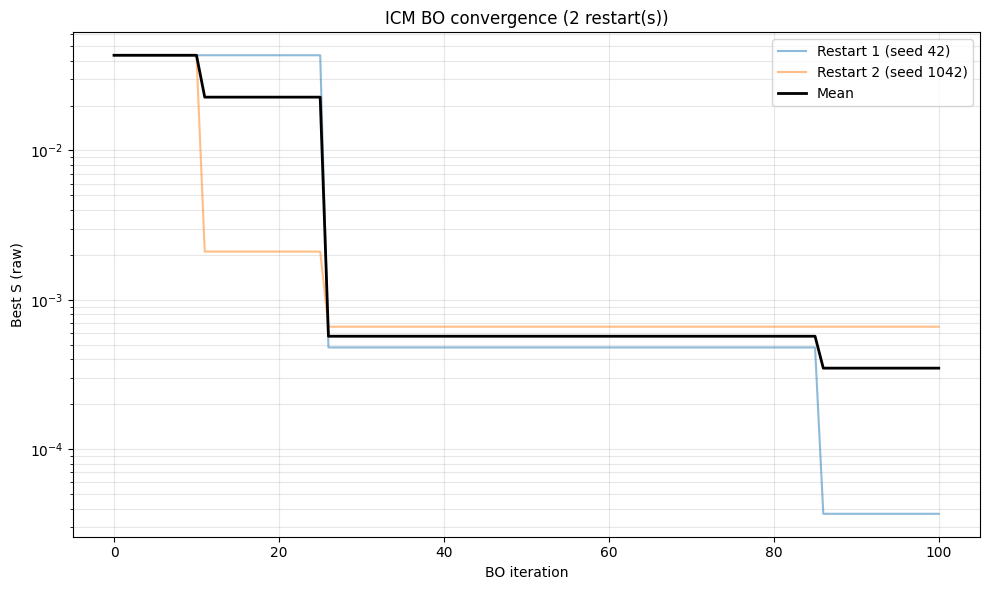

In [64]:
# Plot convergence for all completed restarts (works with in-memory icm_histories_raw)
import matplotlib.pyplot as plt
import numpy as np

if len(icm_histories_raw) == 0:
    print("No restarts in memory. Run the BO loop cell first.")
else:
    min_len = min(len(h) for h in icm_histories_raw)
    xs = np.arange(min_len)
    
    plt.figure(figsize=(10, 6))
    for r, h in enumerate(icm_histories_raw):
        plt.plot(xs, np.array(h[:min_len]), alpha=0.5, label=f"Restart {r+1} (seed {icm_seeds_used[r]})")
    mean_curve = np.mean([np.array(h[:min_len]) for h in icm_histories_raw], axis=0)
    plt.plot(xs, mean_curve, color="black", linewidth=2, label="Mean")
    plt.xlabel("BO iteration")
    plt.ylabel("Best S (raw)")
    plt.title(f"ICM BO convergence ({len(icm_histories_raw)} restart(s))")
    plt.yscale("log")
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot convergence for all completed restarts (works with in-memory icm_histories_raw after early stop)
import matplotlib.pyplot as plt
import numpy as np

if len(icm_histories_raw) == 0:
    print("No restarts in memory. Run the BO loop cell first.")
else:
    min_len = min(len(h) for h in icm_histories_raw)
    xs = np.arange(min_len)
    
    plt.figure(figsize=(10, 6))
    for r, h in enumerate(icm_histories_raw):
        plt.plot(xs, np.array(h[:min_len]), alpha=0.5, label=f"Restart {r+1} (seed {icm_seeds_used[r]})")
    mean_curve = np.mean([np.array(h[:min_len]) for h in icm_histories_raw], axis=0)
    plt.plot(xs, mean_curve, color="black", linewidth=2, label="Mean")
    plt.xlabel("BO iteration")
    plt.ylabel("Best S (raw)")
    plt.title(f"ICM BO convergence ({len(icm_histories_raw)} restart(s))")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

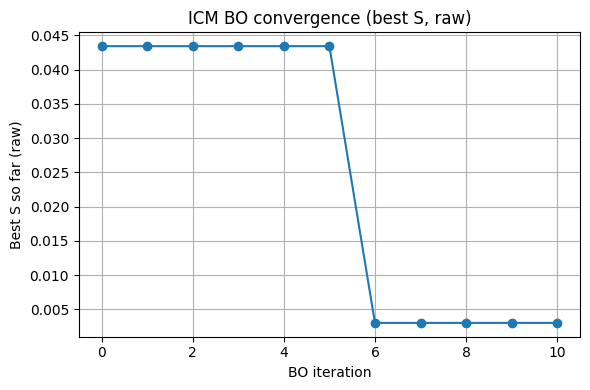

In [37]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(len(S_history_raw))

plt.figure(figsize=(6,4))
plt.plot(iters, S_history_raw, marker="o")
plt.xlabel("BO iteration")
plt.ylabel("Best S so far (raw)")
plt.title("ICM BO convergence (best S, raw)")
plt.grid(True)
plt.tight_layout()
plt.show()

Best OD index: 25
Best OD vector: [451.31922185 625.59160989 977.95972539 855.02316587]
GT OD vector:  [500. 500. 900. 900.]


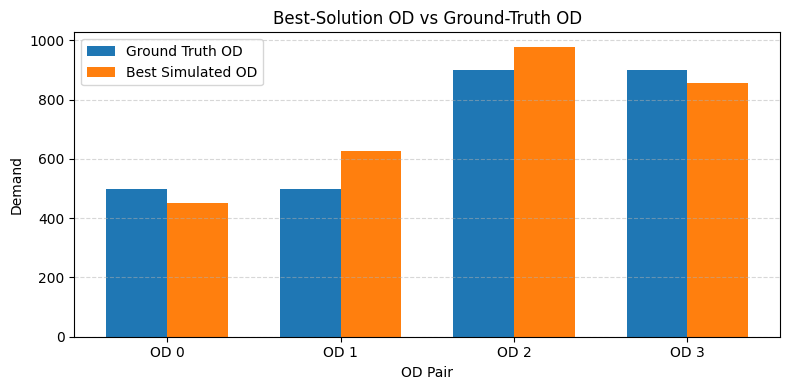

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Compute aggregated loss for all training points if not already defined
if 'S_obs_history_raw' not in locals() and 'S_obs_history_raw' not in globals():
    # Compute S_all_raw from training data
    S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1)
    S_obs_history_raw = S_all_raw.cpu().tolist()

best_idx = int(np.argmin(S_obs_history_raw))
best_od = train_X_icm[best_idx].cpu().numpy() 

# Ground truth OD
gt_od = gt_od_df["count"].astype(float).values  

print("Best OD index:", best_idx)
print("Best OD vector:", best_od)
print("GT OD vector: ", gt_od)

labels = [f"OD {i}" for i in range(len(gt_od))]

x = np.arange(len(gt_od))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, gt_od,  width, label="Ground Truth OD")
plt.bar(x + width/2, best_od, width, label="Best Simulated OD")

plt.xlabel("OD Pair")
plt.ylabel("Demand")
plt.title("Best-Solution OD vs Ground-Truth OD")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## eigenvalues of the task covariance 

In [50]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()
    evals = torch.linalg.eigvalsh(B).flip(0)  # descending
    print(evals[:10])
    print("ratio e3/e2:", (evals[2] / evals[1]).item())

tensor([2.5006e+02, 2.2776e+01, 2.2543e+01, 2.1036e+01, 1.0401e+01, 1.0323e+01,
        1.0209e+01, 6.1769e+00, 9.1888e-05, 8.7093e-05], dtype=torch.float64)
ratio e3/e2: 0.9897725985382874


In [39]:
# Check the actual noise structure
likelihood = icm_model.likelihood
print(f"Likelihood type: {type(likelihood)}")
print(f"Likelihood num_tasks: {likelihood.num_tasks}")

# Check different noise attributes
print(f"\nNoise attributes:")
print(f"  noise: {likelihood.noise.shape if hasattr(likelihood.noise, 'shape') else 'scalar'}")
print(f"  noise.data: {likelihood.noise.data.shape if hasattr(likelihood.noise.data, 'shape') else 'scalar'}")

# Try accessing task-specific noise if it exists
if hasattr(likelihood, 'task_noises'):
    print(f"  task_noises: {likelihood.task_noises.shape if hasattr(likelihood.task_noises, 'shape') else 'N/A'}")
    print(f"  task_noises.data: {likelihood.task_noises.data}")

# List all attributes
print(f"\nAll likelihood attributes containing 'noise':")
for attr in dir(likelihood):
    if 'noise' in attr.lower():
        try:
            val = getattr(likelihood, attr)
            if not callable(val):
                print(f"  {attr}: {val}")
        except:
            pass

Likelihood type: <class 'gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood'>
Likelihood num_tasks: 14

Noise attributes:
  noise: torch.Size([1])
  noise.data: torch.Size([1])
  task_noises: torch.Size([14])
  task_noises.data: tensor([1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0001e-04, 1.0000e+00, 1.0000e+00,
        1.0000e-04, 1.0001e-04, 9.9593e-01, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        9.9924e-01, 1.0000e-04], dtype=torch.float64)

All likelihood attributes containing 'noise':
  has_global_noise: True
  has_task_noise: True
  noise: tensor([1.0000e-04], dtype=torch.float64, grad_fn=<AddBackward0>)
  raw_noise: Parameter containing:
tensor([-33.5200], dtype=torch.float64, requires_grad=True)
  raw_task_noises: Parameter containing:
tensor([-27.3529, -28.5582, -28.7898, -18.5227,  16.5733,  17.0080, -26.4996,
        -18.1627,   5.4997, -32.4818, -27.5946, -31.3245,   7.1827, -32.6136],
       dtype=torch.float64, requires_grad=True)
  task_noises: ten

In [40]:
# Check task-specific noise (this is what you want!)
task_noises = icm_model.likelihood.task_noises.data
num_tasks = len(task_noises)

print(f"Number of tasks (edges): {num_tasks}")
print(f"\nNoise per task:")
print("-" * 50)
for task_idx in range(num_tasks):
    noise_val = task_noises[task_idx].item()
    status = ""
    if abs(noise_val - 1e-4) < 1e-5:
        status = " LOWER LIMIT"
    elif abs(noise_val - 1.0) < 1e-5:
        status = "  UPPER LIMIT"
    print(f"  Task {task_idx:3d}: {noise_val:.6f}{status}")

print("-" * 50)
print(f"Summary: min={task_noises.min():.6f}, max={task_noises.max():.6f}, mean={task_noises.mean():.6f}")

# Check limits
lower_bound = 1e-4
upper_bound = 1.0
at_lower = (task_noises - lower_bound).abs() < 1e-5
at_upper = (task_noises - upper_bound).abs() < 1e-5

if at_lower.any():
    task_indices = torch.where(at_lower)[0].tolist()
    print(f"\n  {at_lower.sum()} task(s) at LOWER limit: tasks {task_indices}")
if at_upper.any():
    task_indices = torch.where(at_upper)[0].tolist()
    print(f"  {at_upper.sum()} task(s) at UPPER limit: tasks {task_indices}")

Number of tasks (edges): 14

Noise per task:
--------------------------------------------------
  Task   0: 0.000100 LOWER LIMIT
  Task   1: 0.000100 LOWER LIMIT
  Task   2: 0.000100 LOWER LIMIT
  Task   3: 0.000100 LOWER LIMIT
  Task   4: 1.000000  UPPER LIMIT
  Task   5: 1.000000  UPPER LIMIT
  Task   6: 0.000100 LOWER LIMIT
  Task   7: 0.000100 LOWER LIMIT
  Task   8: 0.995929
  Task   9: 0.000100 LOWER LIMIT
  Task  10: 0.000100 LOWER LIMIT
  Task  11: 0.000100 LOWER LIMIT
  Task  12: 0.999241
  Task  13: 0.000100 LOWER LIMIT
--------------------------------------------------
Summary: min=0.000100, max=1.000000, mean=0.285441

  10 task(s) at LOWER limit: tasks [0, 1, 2, 3, 6, 7, 9, 10, 11, 13]
  2 task(s) at UPPER limit: tasks [4, 5]


In [41]:
# B matrix (task covariance / coregionalization)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
print("B shape:", B.shape)
print(B)

B shape: torch.Size([14, 14])
tensor([[76.5206, 76.5201, 76.5203,  9.5982,  5.4156,  5.4207,  9.7339,  9.5502,
          5.3151, -5.0613, -5.3005, -5.1588, 32.7448, -4.4740],
        [76.5201, 76.5196, 76.5198,  9.5982,  5.4155,  5.4206,  9.7338,  9.5502,
          5.3151, -5.0612, -5.3005, -5.1587, 32.7446, -4.4740],
        [76.5203, 76.5198, 76.5200,  9.5982,  5.4155,  5.4207,  9.7339,  9.5502,
          5.3151, -5.0613, -5.3005, -5.1587, 32.7447, -4.4740],
        [ 9.5982,  9.5982,  9.5982, 23.9364,  0.6793,  0.6799,  1.2210,  1.1979,
          0.6667, -0.6349, -0.6649, -0.6471,  4.1073, -0.5612],
        [ 5.4156,  5.4155,  5.4155,  0.6793,  0.3834,  0.3836,  0.6889,  0.6759,
          0.3762, -0.3582, -0.3751, -0.3651,  2.3174, -0.3166],
        [ 5.4207,  5.4206,  5.4207,  0.6799,  0.3836,  0.3841,  0.6895,  0.6765,
          0.3765, -0.3585, -0.3755, -0.3654,  2.3196, -0.3169],
        [ 9.7339,  9.7338,  9.7339,  1.2210,  0.6889,  0.6895, 22.4068,  1.2149,
          0.6761, -

In [42]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])
print(corr)

tensor([[ 1.0000,  1.0000,  1.0000,  0.2243,  0.9999,  0.9999,  0.2351,  0.2229,
          1.0000, -0.1771, -0.1861, -0.1798,  1.0000, -0.2015],
        [ 1.0000,  1.0000,  1.0000,  0.2243,  0.9999,  0.9999,  0.2351,  0.2229,
          1.0000, -0.1771, -0.1861, -0.1798,  1.0000, -0.2015],
        [ 1.0000,  1.0000,  1.0000,  0.2243,  0.9999,  0.9999,  0.2351,  0.2229,
          1.0000, -0.1771, -0.1861, -0.1798,  1.0000, -0.2015],
        [ 0.2243,  0.2243,  0.2243,  1.0000,  0.2242,  0.2242,  0.0527,  0.0500,
          0.2243, -0.0397, -0.0417, -0.0403,  0.2243, -0.0452],
        [ 0.9999,  0.9999,  0.9999,  0.2242,  1.0000,  0.9998,  0.2350,  0.2228,
          0.9999, -0.1771, -0.1861, -0.1798,  0.9999, -0.2014],
        [ 0.9999,  0.9999,  0.9999,  0.2242,  0.9998,  1.0000,  0.2350,  0.2228,
          0.9999, -0.1771, -0.1861, -0.1798,  0.9999, -0.2014],
        [ 0.2351,  0.2351,  0.2351,  0.0527,  0.2350,  0.2350,  1.0000,  0.0524,
          0.2351, -0.0416, -0.0438, -0.0423,  0.2

In [44]:
edge_ids = gt_edge_data["edge_id"].tolist()

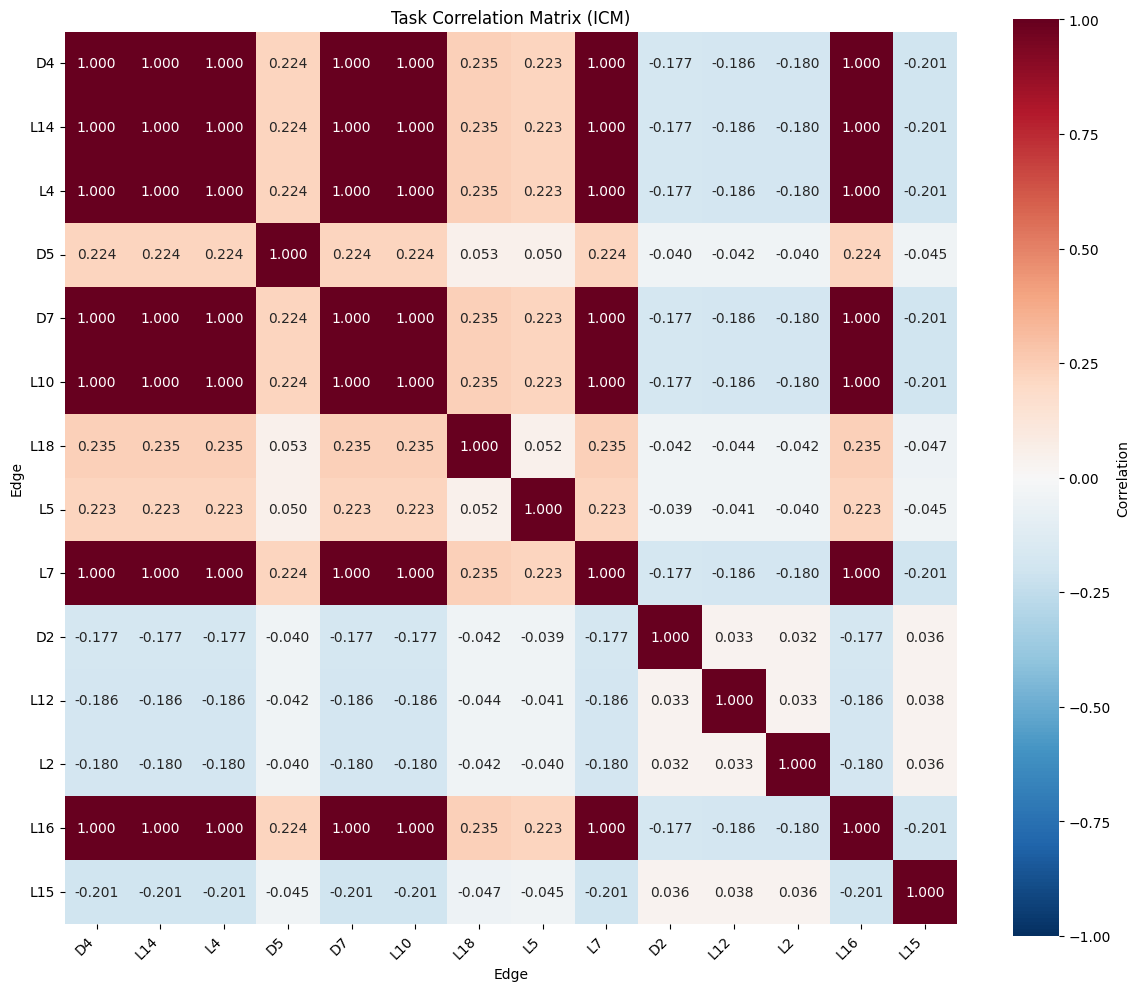

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Compute correlation (your existing code)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

corr_np = corr.detach().cpu().numpy()

# Create heatmap with edge IDs as labels
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=edge_ids,  # Use actual edge IDs
    yticklabels=edge_ids,
)
plt.title('Task Correlation Matrix (ICM)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.xticks(rotation=45, ha='right')  # Rotate labels if needed
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## comparing scalar gp with icm 

In [ ]:
#same
print(train_X_icm_init[1])
print(train_X_icm[1])


tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])
tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])


In [ ]:
"""
GP Hyperparameter Optimization Process:

1. ExactMarginalLogLikelihood (MLL):
   - Computes the marginal log-likelihood: log p(Y | X, θ)
   - Evaluates how well the model explains the data given current hyperparameters θ
   - Provides gradients for optimization
   
   Example:
       mll = ExactMarginalLogLikelihood(model.likelihood, model)
       current_mll = mll()  # log p(Y | X, θ_current)

2. fit_gpytorch_mll:
   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)
   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)
   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)
   
   Example:
       fit_gpytorch_mll(mll)  # Optimizes hyperparameters
       # After fitting, model has optimized θ*

Hyperparameters optimized:
   - Kernel: lengthscales ℓ, output variance σ²_f
   - Task covariance: matrix B (rank-1: parameters b)
   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]
   - Mean: per-task mean μ = [μ₁, ..., μ_L]
"""

'\nGP Hyperparameter Optimization Process:\n\n1. ExactMarginalLogLikelihood (MLL):\n   - Computes the marginal log-likelihood: log p(Y | X, θ)\n   - Evaluates how well the model explains the data given current hyperparameters θ\n   - Provides gradients for optimization\n\n   Example:\n       mll = ExactMarginalLogLikelihood(model.likelihood, model)\n       current_mll = mll()  # log p(Y | X, θ_current)\n\n2. fit_gpytorch_mll:\n   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)\n   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)\n   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)\n\n   Example:\n       fit_gpytorch_mll(mll)  # Optimizes hyperparameters\n       # After fitting, model has optimized θ*\n\nHyperparameters optimized:\n   - Kernel: lengthscales ℓ, output variance σ²_f\n   - Task covariance: matrix B (rank-1: parameters b)\n   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]\n   - Mean: per-task mean μ = [μ₁, ..., μ_L]\n'

# ICM with cubic error and 10 inital point 

In [ ]:
from src.utils.link_flow_analysis import compute_cubic_metric_per_edge

csv_path = Path(f"{config['simulation_run_path']}/initial_search/data_set_ods_10init_cubic.csv")
#renamed for 10 initial points and cubic error

# Flow-proportional weights for cubic metric:
#   w_l = s_l^GT / (L * F_tot^GT)
# where F_tot^GT = sum_j s_j^GT (total GT flow over edges).
# Then sum_l w_l = 1/L (not 1).
gt_flows = gt_edge_data.set_index("edge_id").loc[edge_ids, "interval_nVehContrib"].values.astype(float)
L = len(edge_ids)
total_flow = gt_flows.sum()
weights_flow_np = gt_flows / (L * total_flow)




if csv_path.exists():
    print(f"Loading initial data from {csv_path}")
    df_initial_bo = pd.read_csv(csv_path)

    x_cols = [col for col in df_initial_bo.columns if col.startswith("x_")]
    x_cols.sort(key=lambda x: int(x.split("_")[1]))
    e_cols = [col for col in df_initial_bo.columns if col.startswith("e_")]

    train_X_list = []
    train_E_list = []
    S_list = []

    for _, row in df_initial_bo.iterrows():
        train_X_list.append(row[x_cols].values.astype(float))
        train_E_list.append(row[e_cols].values.astype(float))
        S_list.append(float(row["loss"]))

    print(f"  Loaded {len(train_X_list)} initial points")
    print(f"  OD dimension: {len(x_cols)}, Edges: {len(e_cols)}")

else:
    train_X_list = []     
    train_E_list = []    
    S_list       = []      

    batch_data_i = []    
    N_REP = 1

    for i, x in enumerate(train_X0.tolist()):
        print(f"Initial OD: {i}")
        curr_od = np.array(x, dtype=float)
        print(curr_od)
        print(f"total expected demand: {np.sum(curr_od)}")

        simulation_run_path_init = f"{config['simulation_run_path']}/initial_search/10init_cubic"
        Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

        # OD xml for this candidate 
        new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
        prefix_output_base = f"{simulation_run_path_init}/sobol_{i}"

        base_od = gt_od_df.copy()
        base_od["count"] = curr_od
        base_od["count"] = [round(v, 1) for v in base_od["count"]]
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        per_edge_errors_reps = []

        for rep in range(N_REP):
            print(f"Replication {rep}")
            prefix_output_rep = f"{prefix_output_base}_rep{rep}"

            simulate_od(
                new_od_xml,
                prefix_output_rep,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
                sim_start_time=0,
                seed=rep,   # different seed per replication
            )

            sim_edge_out_rep = f"{prefix_output_rep}_{config['EDGE_OUT_STR']}"
            curr_loop_stats_rep, _, _ = parse_loop_data_xml_to_pandas(
                base_path,
                sim_edge_out_rep,
                prefix_output_rep,
                config["SUMO_PATH"],
            )

            # simulated flows per edge
            sim_counts = (
                curr_loop_stats_rep[curr_loop_stats_rep["edge_id"].isin(edge_ids)]
                .set_index("edge_id")["interval_nVehContrib"]
                .loc[edge_ids]  # preserve order
                .values
            )

            print(f"\n Simulated flows for replication {rep}")
            for edge_id, count in zip(edge_ids, sim_counts):
                print(f"  {edge_id}: {count}")

            # per-edge error for this replication (e_l(x)), if we assume mutltiple replication keep compute_squared_metric_per_edge otherwise compute_nrmse_all_edges can be used
            # compute cubic error
            per_edge_errors_rep = compute_cubic_metric_per_edge(
                df_true=gt_edge_data,
                df_simulated=curr_loop_stats_rep,
                edge_ids=edge_ids,
            )  # np.array [L]

            per_edge_errors_reps.append(per_edge_errors_rep)

        per_edge_errors_reps = np.stack(per_edge_errors_reps, axis=0)  # [N_REP, L]
        per_edge_errors = per_edge_errors_reps.mean(axis=0)            # [L]

        # aggregated scalar loss S(x) = Σ_l w_l e_l(x) —- weight sum to 1/L 
        S_x = float((per_edge_errors * weights_flow_np).sum())
        print(f"aggregated loss S(x): {S_x}")

        train_X_list.append(curr_od.copy())
        train_E_list.append(per_edge_errors.copy())
        S_list.append(S_x)

        df_curr = pd.DataFrame(
            curr_od.reshape(1, -1),
            columns=[f"x_{k+1}" for k in range(curr_od.shape[0])]
        )
        df_curr["loss"] = S_x

        # Add per-edge errors as columns (e_edge_id for each edge)
        for edge_idx, edge_id in enumerate(edge_ids):
            df_curr[f"e_{edge_id}"] = per_edge_errors[edge_idx]

        batch_data_i.append(df_curr)

    # Save initial dataset
    if batch_data_i:
        df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
        df_initial_bo.to_csv(csv_path, index=False)
        print(f"✓ Saved initial data to {csv_path}")

Loading initial data from output/quickstart_bo_vanilla_matern-2p5/initial_search/data_set_ods_10init_cubic.csv
  Loaded 10 initial points
  OD dimension: 4, Edges: 14


In [ ]:
# ========== ICM rank-1 BO with CUBIC error — corrected + consistent ==========
# - Train ICM on standardized per-edge errors: z = (y - mu)/sigma  (mu,sigma frozen within restart)
# - EI optimizes scalar g(x) = sum_l (w_l * sigma_l) * z_l(x), which is aligned with RAW S(x)=sum_l w_l y_l(x) up to a constant
# - Track RAW best_S (the thing you actually care about)


import json
import numpy as np
import pandas as pd
import torch
from pathlib import Path

from botorch.acquisition import ExpectedImprovement
from botorch.exceptions import ModelFittingError
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from linear_operator.utils.errors import NotPSDError

from src.utils.link_flow_analysis import compute_cubic_metric_per_edge
from src.utils.seed import set_seed
from MOGP.helpers_MOGP import initialize_icm_gp, LinearAggregationICM

# =========================
# Basic setup
# =========================
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# From initial data train_X_list, train_E_list from CSV or initial design
train_X = torch.tensor(np.array(train_X_list), dtype=dtype, device=device)          # (N, d)
train_Y_errors = torch.tensor(np.array(train_E_list), dtype=dtype, device=device)  # (N, L)

# Ensure edge_ids is a python list
if hasattr(edge_ids, "tolist"):
    edge_ids = edge_ids.tolist()

# Flow-proportional weights: w_l = s_l^GT / (L * F_tot^GT)  (note: sums to 1/L)
gt_flows = (
    gt_edge_data.set_index("edge_id")
    .loc[edge_ids, "interval_nVehContrib"]
    .values.astype(float)
)
L = len(edge_ids)
F_tot_GT = gt_flows.sum()
weights_flow_np = gt_flows / (L * F_tot_GT)
weights_flow_t = torch.tensor(weights_flow_np, dtype=dtype, device=device)  # (L,)

# BO hyperparams
N_BO_ITERS = 100
N_RESTARTS = 5
raw_samples = config.get("BO_sample_shape", 128)
num_restarts_acq = config.get("BO_num_restarts", 10)
BO_FOLDER = "icm_bo_cubic"
RANK = 1

# Bounds (OD space). You said OD start is 1.
d = train_X.shape[1]
od_bound_start = config.get("od_bound_start", 1)
od_bound_end = config.get("od_bound_end", 2000)
bounds = torch.stack(
    [
        torch.full((d,), od_bound_start, dtype=dtype, device=device),
        torch.full((d,), od_bound_end, dtype=dtype, device=device),
    ]
)
bounds_norm = torch.stack(
    [
        torch.zeros(d, dtype=dtype, device=device),
        torch.ones(d, dtype=dtype, device=device),
    ]
)

# Debug: ensure initial X within bounds
assert train_X.min() >= od_bound_start and train_X.max() <= od_bound_end, (
    f"train_X should be in [{od_bound_start}, {od_bound_end}]. "
    f"Use same bounds in initial-data."
)

# Early stop + skip
use_early_stop = config.get("EARLY_STOP_ENABLED", False)
EARLY_STOP_PATIENCE = config.get("EARLY_STOP_PATIENCE", 0) if use_early_stop else 0
EARLY_STOP_DELTA = config.get("EARLY_STOP_DELTA", 1e-6)
EARLY_STOP_MIN_ACQ = config.get("EARLY_STOP_MIN_ACQ", 0.0)
skip_if_saved = config.get("SKIP_RESTART_IF_SAVED", True)

# Save dirs
save_base = Path(config["simulation_run_path"]) / BO_FOLDER
save_base.mkdir(parents=True, exist_ok=True)
results_dir = save_base / "results"
results_dir.mkdir(parents=True, exist_ok=True)
initial_design_path = results_dir / "initial_design_cubic.npz"

# =========================
# Load/save initial design (frozen across restarts)
# =========================
if initial_design_path.exists():
    data = np.load(initial_design_path)
    train_X_init = torch.tensor(data["train_X"], dtype=dtype, device=device)
    train_Y_errors_init = torch.tensor(data["train_Y"], dtype=dtype, device=device)
    print(
        f"[INIT] Loaded initial design from {initial_design_path} "
        f"(N={train_X_init.shape[0]}, d={train_X_init.shape[1]})"
    )
else:
    train_X_init = train_X.clone()
    train_Y_errors_init = train_Y_errors.clone()
    np.savez(
        initial_design_path,
        train_X=train_X_init.cpu().numpy(),
        train_Y=train_Y_errors_init.cpu().numpy(),
    )
    print(
        f"[INIT] Saved initial design to {initial_design_path} "
        f"(N={train_X_init.shape[0]}, d={train_X_init.shape[1]})"
    )

icm_histories = []

# =========================
# BO restarts
# =========================
for r in range(N_RESTARTS):
    seed = 42 + r * 1000
    restart_dir = results_dir / f"restart_{r+1}_seed-{seed}"
    convergence_file = restart_dir / "convergence.csv"

    if skip_if_saved and convergence_file.exists():
        S_history = pd.read_csv(convergence_file)["best_S"].tolist()
        icm_histories.append(S_history)
        print(
            f"\n######### ICM (rank-1 cubic) RESTART {r+1}/{N_RESTARTS} (seed={seed}) — SKIPPED #########"
        )
        print(f"  Loaded {len(S_history)} iterations, best S = {S_history[-1]:.6f}")
        continue

    set_seed(seed)
    print(f"\n######### ICM (rank-1 cubic) RESTART {r+1}/{N_RESTARTS} (seed={seed}) #########")

    # Start from same initial design for each restart
    train_X_bo = train_X_init.clone()                # (N, d)
    train_Y_errors_bo = train_Y_errors_init.clone()  # (N, L)

    # ---- standardization stats (frozen within restart) ----
    # (1, L)
    y_mean = train_Y_errors_bo.mean(dim=0, keepdim=True)
    y_std = train_Y_errors_bo.std(dim=0, keepdim=True, unbiased=False).clamp_min(1e-6)

    # z-space training targets (N, L)
    train_Y_std = (train_Y_errors_bo - y_mean) / y_std

    # weights for z-space scalar that aligns with RAW S up to a constant:
    # S_raw(x)=sum_l w_l y_l(x) = const + sum_l (w_l*sigma_l) z_l(x)
    w_std = weights_flow_t * y_std.squeeze(0)  # (L,)

    # RAW scalar on the initial dataset
    S_agg_raw = (train_Y_errors_bo * weights_flow_t).sum(dim=1)  # (N,)
    best_S_raw = float(S_agg_raw.min().item())

    S_history = [best_S_raw]
    best_checkpoint = best_S_raw
    no_improve_steps = 0

    print(f"[BO INIT] N={train_X_bo.shape[0]}, best S (raw) = {best_S_raw:.6f}\n")
    if EARLY_STOP_PATIENCE > 0:
        print(f"  EARLY STOP: patience={EARLY_STOP_PATIENCE}, delta={EARLY_STOP_DELTA:.6e}")

    # =========================
    # BO iterations
    # =========================
    for it in range(N_BO_ITERS):
        # normalize X to [0,1]^d for the GP
        train_X_norm = normalize(train_X_bo, bounds=bounds)

        # standardized targets using frozen stats (recompute after appends)
        train_Y_std = (train_Y_errors_bo - y_mean) / y_std

        # fit ICM GP in standardized space
        icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_std, rank=RANK)
        icm_model = icm_model.to(device=device, dtype=dtype)
        icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
        mll = mll.to(device=device, dtype=dtype)

        try:
            fit_gpytorch_mll(mll)
        except (NotPSDError, RuntimeError, ModelFittingError):
            print("[Fallback] Using Adam optimizer due to GP fitting failure.")

            mll.model.train()
            mll.model.likelihood.train()
            optimizer = torch.optim.Adam(mll.parameters(), lr=0.01)

            for _ in range(200):
                optimizer.zero_grad()
                output = mll.model(train_X_norm)
                loss = -mll(output, train_Y_std)
                loss.backward()
                optimizer.step()

        icm_model.eval()

        # Aggregate in standardized space with w_std so EI targets RAW S (up to constant)
        agg_model = LinearAggregationICM(
            icm_model, w_std, normalize_weights=False
        ).to(device=device, dtype=dtype)
        agg_model.eval()

        # best_f must be in the same space as agg_model outputs (g-space)
        g_agg = (train_Y_std * w_std).sum(dim=1)  # (N,)
        best_f_for_ei = g_agg.min()

        acqf = ExpectedImprovement(model=agg_model, best_f=best_f_for_ei, maximize=False)

        x_next_norm, acq_val = optimize_acqf(
            acqf,
            bounds=bounds_norm,
            q=1,
            num_restarts=num_restarts_acq,
            raw_samples=raw_samples,
        )
        x_next_norm = x_next_norm.detach()
        x_next_real = unnormalize(x_next_norm, bounds).squeeze(0).cpu().numpy()
        x_next_real = np.clip(x_next_real, od_bound_start, od_bound_end)

        # =========================
        # Run simulation at x_next_real
        # =========================
        sim_dir = (
            Path(config["simulation_run_path"])
            / BO_FOLDER
            / f"restart_{r+1}_seed-{seed}"
            / f"iter_{it}"
        )
        sim_dir.mkdir(parents=True, exist_ok=True)
        od_xml = sim_dir / "od.xml"
        prefix_output = sim_dir / "sim"

        base_od = gt_od_df.copy()
        base_od["count"] = [round(v, 1) for v in x_next_real]
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(str(od_xml), base_od, config["od_duration_sec"], base_path)
        simulate_od(
            str(od_xml),
            str(prefix_output),
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_path, sim_edge_out, str(prefix_output), str(config["SUMO_PATH"])
        )

        per_edge_cubic = compute_cubic_metric_per_edge(gt_edge_data, curr_loop_stats, edge_ids)
        if np.any(np.isnan(per_edge_cubic)):
            raise RuntimeError("NaN in cubic metric — unexpected with OD ≥ 1.")

        e_next_tensor = torch.tensor(per_edge_cubic, dtype=dtype, device=device)  # (L,)
        S_next = (e_next_tensor * weights_flow_t).sum().item()
        best_S_raw = min(best_S_raw, S_next)

        # append training data (RAW per-edge errors)
        train_X_bo = torch.cat(
            [train_X_bo, torch.tensor(x_next_real, dtype=dtype, device=device).unsqueeze(0)], dim=0
        )
        train_Y_errors_bo = torch.cat([train_Y_errors_bo, e_next_tensor.unsqueeze(0)], dim=0)

        S_history.append(best_S_raw)

        # save compare table for this iter
        merged_data = pd.merge(
            gt_edge_data[["edge_id", "interval_nVehContrib"]],
            curr_loop_stats[["edge_id", "interval_nVehContrib"]],
            on="edge_id",
            suffixes=("_gt", "_sim"),
        )
        merged_data.to_csv(sim_dir / "link_measure_compare.csv", index=False)
        (sim_dir / f"LOSS_{S_next:.6f}.txt").write_text(f"LOSS: {S_next:.6f}")

        # cleanup
        if config.get("CLEANUP_INTERMEDIATE_FILES", False):
            try:
                if Path(sim_edge_out).exists():
                    Path(sim_edge_out).unlink()
            except Exception as e:
                print(f"[Warning] Cleanup: {e}")

        # early stopping on RAW objective
        if EARLY_STOP_PATIENCE > 0:
            delta = best_checkpoint - best_S_raw
            if delta >= EARLY_STOP_DELTA:
                best_checkpoint = best_S_raw
                no_improve_steps = 0
            else:
                no_improve_steps += 1
                if no_improve_steps >= EARLY_STOP_PATIENCE:
                    print(
                        f"\nEARLY STOP: no improvement ≥ {EARLY_STOP_DELTA} for {EARLY_STOP_PATIENCE} iters. "
                        f"Best S: {best_S_raw:.6f}\n"
                    )
                    break

        if EARLY_STOP_MIN_ACQ > 0 and acq_val.item() < EARLY_STOP_MIN_ACQ:
            print(f"\nEARLY STOP: EI < {EARLY_STOP_MIN_ACQ}. Best S: {best_S_raw:.6f}\n")
            break

        print(
            f"[BO iter {it+1}/{N_BO_ITERS}] "
            f"S(x_next)={S_next:.6f}, best S={best_S_raw:.6f}, EI={acq_val.item():.6f}"
        )

    # end iterations
    icm_histories.append(S_history)
    print(f"\n[RESTART {r+1} COMPLETE] Final best S = {best_S_raw:.6f}")

    restart_dir.mkdir(parents=True, exist_ok=True)
    pd.DataFrame({"iteration": range(len(S_history)), "best_S": S_history}).to_csv(
        restart_dir / "convergence.csv", index=False
    )

# =========================
# Summarize across restarts
# =========================
max_len = max(len(h) for h in icm_histories)
padded = np.full((N_RESTARTS, max_len), np.nan)
for i, h in enumerate(icm_histories):
    padded[i, :len(h)] = h

mean_curve = np.nanmean(padded, axis=0)
std_curve = np.nanstd(padded, axis=0)

best_S_per_restart = [h[-1] for h in icm_histories]
overall_best = min(best_S_per_restart)

print("\n" + "=" * 60)
print("ICM (rank-1 cubic) BO COMPLETE")
print("=" * 60)
print(f"Restarts: {N_RESTARTS}, Iterations per restart: {N_BO_ITERS}")
print(f"Best S per restart: {[f'{s:.6f}' for s in best_S_per_restart]}")
print(f"Mean best S: {np.mean(best_S_per_restart):.6f} ± {np.std(best_S_per_restart):.6f}")
print(f"Overall best S: {overall_best:.6f}")
print("=" * 60)

conv_df = pd.DataFrame(
    {
        "iteration": range(len(mean_curve)),
        "best_S_mean": mean_curve,
        "best_S_std": std_curve,
    }
)
conv_df.to_csv(results_dir / "convergence_mean_std.csv", index=False)

with open(results_dir / "summary.json", "w") as f:
    json.dump(
        {
            "best_S_per_restart": best_S_per_restart,
            "best_S_mean": float(np.mean(best_S_per_restart)),
            "best_S_std": float(np.std(best_S_per_restart)),
            "overall_best_S": float(overall_best),
            "n_restarts": N_RESTARTS,
            "n_bo_iters": N_BO_ITERS,
            "n_initial": train_X_init.shape[0],
            "rank": RANK,
            "metric": "cubic",
            "od_bound_start": od_bound_start,
            "od_bound_end": od_bound_end,
        },
        f,
        indent=2,
    )

df_histories = pd.DataFrame(
    {
        f"restart_{i+1}": icm_histories[i] + [np.nan] * (max_len - len(icm_histories[i]))
        for i in range(N_RESTARTS)
    }
)
df_histories["mean"] = mean_curve
df_histories.index.name = "iteration"
df_histories.to_csv(results_dir / "all_restarts_convergence.csv")

print(f"\n✓ Saved: {results_dir}")
print("  - results/restart_X_seed-Y/convergence.csv (written after each restart)")
print("  - convergence_mean_std.csv, summary.json, all_restarts_convergence.csv")



[INIT] Loaded initial design from output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/results/initial_design_cubic.npz (N=10, d=4)

######### ICM (rank-1 cubic) RESTART 1/5 (seed=42) #########
[BO INIT] N=10, best S (raw) = 0.043419



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_0/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_1/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_2/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_3/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_4/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_5/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_6/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_7/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_8/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_9/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_10/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_11/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_12/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_13/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_14/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_15/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_16/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_17/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_18/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_19/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_20/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_21/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_22/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_23/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_24/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_25/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_26/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_27/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_28/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_29/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_29/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_30/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_31/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_32/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_33/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_34/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_35/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_36/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_36/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_37/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_38/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_38/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_39/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_40/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_40/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_41/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_42/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_42/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_43/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_43/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_44/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_44/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_45/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_46/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_46/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_47/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_47/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_48/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_48/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_49/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_49/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_50/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_50/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_51/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_52/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_53/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_53/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_54/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_54/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_55/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_56/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_56/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_57/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_57/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_58/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_58/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_59/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_59/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_60/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_60/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_61/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_62/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_62/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_63/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_63/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_64/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_64/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_65/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_65/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_66/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_66/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_67/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_67/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_68/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_68/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_69/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_69/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_70/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_70/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_71/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_71/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_72/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_72/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_73/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_73/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_74/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_74/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_75/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_75/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_76/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_76/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_77/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_77/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_78/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_78/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_79/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_79/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_80/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_80/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_81/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_81/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_82/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_82/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_83/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_83/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_84/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_84/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_85/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_85/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_86/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_86/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_87/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_87/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_88/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_88/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_89/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_89/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_90/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_90/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_91/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_91/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_92/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_92/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_93/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_93/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_94/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_94/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_95/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_95/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_96/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_96/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_97/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_97/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_98/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_98/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_99/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_1_seed-42/iter_99/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_cal

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_0/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_1/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_2/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_3/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_4/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_5/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_6/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_7/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_8/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_9/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_10/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_11/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_12/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_13/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_14/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_15/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_16/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_17/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_18/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_19/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_20/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_21/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_22/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_23/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_24/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_25/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_26/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_27/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_28/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_29/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_29/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_30/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_31/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_32/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_33/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_34/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_35/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_36/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_36/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_37/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_38/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_38/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_39/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_40/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_40/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_41/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_42/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_42/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_43/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_43/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_44/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_44/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_45/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_46/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_46/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_47/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_47/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_48/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_48/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_49/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_49/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_50/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_50/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_51/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_52/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_53/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_53/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_54/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_54/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_55/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_56/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_56/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_57/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_57/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_58/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_58/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_59/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_59/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_60/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_60/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_61/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_62/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_62/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_63/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_63/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_64/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_64/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_65/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_65/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_66/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_66/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_67/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_67/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_68/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_68/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_69/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_69/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_70/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_70/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_71/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_71/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_72/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_72/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_73/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_73/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_74/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_74/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_75/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_75/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_76/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_76/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_77/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_77/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_78/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_78/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_79/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_79/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_80/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_80/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_81/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_81/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_82/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_82/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_83/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_83/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_84/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_84/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_85/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_85/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_86/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_86/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_87/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_87/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_88/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_88/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_89/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_89/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_90/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_90/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_91/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_91/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_92/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_92/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_93/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_93/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_94/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_94/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_95/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_95/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_96/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_96/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_97/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_97/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_98/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_98/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_99/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_2_seed-1042/iter_99/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_0/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_1/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_2/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_3/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_4/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_5/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_6/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_7/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_8/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_9/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_10/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_11/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_12/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_13/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_14/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_15/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_16/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_17/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_18/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_19/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_20/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_21/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_22/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_23/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_24/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_25/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_26/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_27/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_28/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_29/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_29/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_30/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_31/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_32/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_33/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_34/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_35/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_36/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_36/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_37/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_38/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_38/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_39/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_40/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_40/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_41/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_42/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_42/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_43/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_43/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_44/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_44/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_45/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_46/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_46/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_47/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_47/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_48/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_48/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_49/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_49/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_50/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_50/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_51/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_52/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_53/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_53/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_54/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_54/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_55/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_56/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_56/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_57/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_57/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_58/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_58/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_59/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_59/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_60/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_60/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_61/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_62/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_62/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_63/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_63/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_64/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_64/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_65/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_65/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_66/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_66/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_67/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_67/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_68/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_68/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_69/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_69/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_70/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_70/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_71/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_71/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_72/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_72/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_73/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_73/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_74/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_74/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_75/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_75/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_76/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_76/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_77/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_77/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_78/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_78/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_79/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_79/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_80/sim_trips_beforeRteUpdates.xml
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla_matern-2p5/icm_bo_cubic/restart_3_seed-2042/iter_80/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/S

# convegrence curve 

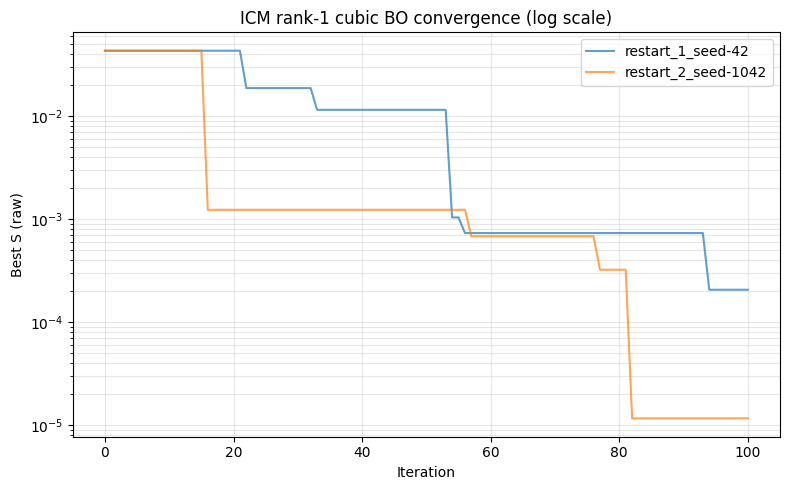

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

base_path = Path("/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn")
results_dir = base_path / "output" / "quickstart_bo_vanilla_matern-2p5" / "icm_bo_cubic" / "results"

fig, ax = plt.subplots(figsize=(8, 5))
for restart_dir in sorted(results_dir.glob("restart_*_seed-*")):
    conv_path = restart_dir / "convergence.csv"
    if conv_path.exists():
        df = pd.read_csv(conv_path)
        # avoid log(0): clip to small positive for log scale
        best_S = np.maximum(df["best_S"].values, 1e-10)
        ax.plot(df["iteration"], best_S, alpha=0.7, lw=1.5, label=restart_dir.name)

ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("Best S (raw)")
ax.set_title("ICM rank-1 cubic BO convergence (log scale)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()